# Setup

In [1]:
pip install -r ../../requirements.txt

/bin/bash: /anaconda/envs/jupyter_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple/, https://****@pkgs.dev.azure.com/parsionate-ai/ps-libraries/_packaging/pypi-feed/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
# Add directory above current directory to path
import sys

sys.path.insert(0, '../..')

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from utils.text_processing import CharTokenizer

In [5]:
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.get_memory_info("GPU:0")

2023-06-10 07:54:06.747075: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [6]:
config = json.load(open("./configs/mnn_em_mscoco.json"))

In [7]:
tmp_path = "/mnt/azmnt/mscoco"

In [8]:
train = pd.read_csv(os.path.join(config["data"]["path"], "train2014.csv"))
train = train.drop({"Unnamed: 0"}, axis=1)
train = train[['description', 'path', 'label']]
train

,description,path,label
0,man eats pancaked and drinks while smiling.,COCO_train2014_000000539573.jpg,1
1,a woman flying a kite underneath a very blue sky.,COCO_train2014_000000021459.jpg,0
2,a statue of a man is holding hands with two ch...,COCO_train2014_000000578497.jpg,0
3,dessert on a white plate next to a silver fork.,COCO_train2014_000000481039.jpg,0
4,a row of transit buses at a traffic light cros...,COCO_train2014_000000252779.jpg,1
...,...,...,...
828221,a brown bear stands on a rock while a forest i...,COCO_train2014_000000069350.jpg,1
828222,this kitchen has all white cabinets and a blac...,COCO_train2014_000000548559.jpg,0
828223,a woman swinging a baseball bat while standing...,COCO_train2014_000000525580.jpg,1
828224,a male is skateboarding on a railing near the ...,COCO_train2014_000000237224.jpg,0


In [9]:
val = pd.read_csv(os.path.join(config["data"]["path"], "val2014.csv"))
val = val.drop({"Unnamed: 0"}, axis=1)
val = val[['description', 'path', 'label']]
val

,description,path,label
0,a view of several parking lots from an airplane.,COCO_val2014_000000142940.jpg,0
1,a group of snowboarders in the snowy conditions,COCO_val2014_000000004554.jpg,1
2,two kittens steep in a terra cotta pot.,COCO_val2014_000000568690.jpg,0
3,two tennis players shaking hands on the court,COCO_val2014_000000076468.jpg,1
4,"the interstate is void of traffic by the exit,...",COCO_val2014_000000434148.jpg,0
...,...,...,...
405303,two lounges are pictured next to a beautiful p...,COCO_val2014_000000004509.jpg,0
405304,a bench has been built next to an old stone bu...,COCO_val2014_000000330750.jpg,1
405305,a man putting a turkey into the oven.,COCO_val2014_000000533452.jpg,1
405306,several elephants dressed for the circus are i...,COCO_val2014_000000292685.jpg,1


In [10]:
img_train = train[["path"]]  # two brackets for keeping the column name
text_train = train["description"]
labels_train = train[["label"]]

In [11]:
img_val = val[["path"]]  # two brackets for keeping the column name
text_val = val["description"]
labels_val = val[["label"]]

# Loading data

# Text processing

## Tokenize texts

In [12]:
tk = CharTokenizer(config["data"]["alphabet"])
text_train = tk.tokenize(text_train)
text_train.shape

(828226, 1014)

In [13]:
text_val = tk.tokenize(text_val)
text_val.shape

(405308, 1014)

## Create embedding weights

In [14]:
weights = tk.create_embedding_weights()
weights.shape

(66, 65)

# Image processing

## Load image model

In [15]:
from utils.img_processing import load_img_model, create_embeddings_from

In [16]:
img_model = load_img_model(config["img_model"])

img_model.output_shape

(None, 576)

## Create image embeddings

In [ ]:
# Mobilenetv3small:
# batch_size = 1024 -> 8 GB VRAM
# batch_size = 2048 -> 16 GB VRAM
# ...
# Mobilenetv3large: twice as much as Mobilenetv3small

img_train = create_embeddings_from(img_model,
                                    img_train,
                                    os.path.join(tmp_path,
                                                "train2014"),
                                    batch_size=1024)

Found 828226 validated image filenames.


2023-06-09 21:55:38.751381: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1908232704 exceeds 10% of free system memory.


In [ ]:
img_train.shape

(828226, 576)

In [ ]:
img_val = create_embeddings_from(img_model,
                                    img_val,
                                    os.path.join(tmp_path,
                                                "val2014"),
                                    batch_size=1024)

Found 405308 validated image filenames.


In [ ]:
img_val.shape

(405308, 576)

# Save embeddings

In [17]:
save_path = os.path.join(config["data"]["path"],
                         f"embeddings/{img_model.name}")

In [ ]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/img_train.npy", img_train)
np.save(f"{save_path}/text_train.npy", text_train)
train.to_csv(f"{save_path}/train.csv")

In [ ]:
np.save(f"{save_path}/img_val.npy", img_val)
np.save(f"{save_path}/text_val.npy", text_val)
val.to_csv(f"{save_path}/val.csv")

## Verify import

In [18]:
train = pd.read_csv(f"{save_path}/train.csv")
train = train.drop({"Unnamed: 0"}, axis=1)
train

,description,description2,path,label
0,man eats pancaked and drinks while smiling.,man eats pancaked and drinks while smiling.,COCO_train2014_000000539573.jpg,1
1,a woman flying a kite underneath a very blue sky.,a woman catching a frisbee as a man looks onward.,COCO_train2014_000000021459.jpg,0
2,a statue of a man is holding hands with two ch...,a large bed in a room with a fireplace.,COCO_train2014_000000578497.jpg,0
3,dessert on a white plate next to a silver fork.,a meal on a paper plate set on a wood table.,COCO_train2014_000000481039.jpg,0
4,a row of transit buses at a traffic light cros...,a row of transit buses at a traffic light cros...,COCO_train2014_000000252779.jpg,1
...,...,...,...,...
828221,a brown bear stands on a rock while a forest i...,a brown bear stands on a rock while a forest i...,COCO_train2014_000000069350.jpg,1
828222,this kitchen has all white cabinets and a blac...,a man dressed as jesus holding a cell phone,COCO_train2014_000000548559.jpg,0
828223,a woman swinging a baseball bat while standing...,a woman swinging a baseball bat while standing...,COCO_train2014_000000525580.jpg,1
828224,a male is skateboarding on a railing near the ...,"an effigy of a man, strapped to a poll",COCO_train2014_000000237224.jpg,0


In [19]:
img_train = np.load(f"{save_path}/img_train.npy", allow_pickle=True)
img_train.shape

(828226, 576)

In [20]:
text_train = np.load(f"{save_path}/text_train.npy", allow_pickle=True)
text_train.shape

(828226, 1014)

In [21]:
val = pd.read_csv(f"{save_path}/val.csv")
val = val.drop({"Unnamed: 0"}, axis=1)
val

,description,description2,path,label
0,a view of several parking lots from an airplane.,a blue and white vase and some blue and white ...,COCO_val2014_000000142940.jpg,0
1,a group of snowboarders in the snowy conditions,a group of snowboarders in the snowy conditions,COCO_val2014_000000004554.jpg,1
2,two kittens steep in a terra cotta pot.,two horses fenced in grazing on the grass.,COCO_val2014_000000568690.jpg,0
3,two tennis players shaking hands on the court,two tennis players shaking hands on the court,COCO_val2014_000000076468.jpg,1
4,"the interstate is void of traffic by the exit,...",a man standing in the forefront of a large clock.,COCO_val2014_000000434148.jpg,0
...,...,...,...,...
405303,two lounges are pictured next to a beautiful p...,a fishing vessel in shallow water at low tide,COCO_val2014_000000004509.jpg,0
405304,a bench has been built next to an old stone bu...,a bench has been built next to an old stone bu...,COCO_val2014_000000330750.jpg,1
405305,a man putting a turkey into the oven.,a man putting a turkey into the oven.,COCO_val2014_000000533452.jpg,1
405306,several elephants dressed for the circus are i...,several elephants dressed for the circus are i...,COCO_val2014_000000292685.jpg,1


In [22]:
img_val = np.load(f"{save_path}/img_val.npy", allow_pickle=True)
img_val.shape

(405308, 576)

In [23]:
text_val = np.load(f"{save_path}/text_val.npy", allow_pickle=True)
text_val.shape

(405308, 1014)

# Save Char CNN config

In [24]:
from models.char_cnn_zhang import CharCNNZhang

In [25]:
char_cnn_config = {
    "input_size": config["data"]["input_size"],
    "embedding_size": len(tk.word_index),
    "conv_layers": config["char_cnn_zhang"]["conv_layers"],
    "fc_layers": config["char_cnn_zhang"]["fc_layers"],
    "output_size": config["char_cnn_zhang"]["output_size"],
    "embedding_weights": weights
}

In [26]:
char_cnn = CharCNNZhang(**char_cnn_config)

# Build MNN-EM Model

![](../../assets/images/MNN_EM.png)

In [27]:
from models.mnn_em import MNNEM
from utils.metrics import create_metrics

In [28]:
head_config = {
    "img_input_size": img_model.layers[-1].output_shape[1],
    "txt_input_size": config["data"]["input_size"],
    "img_fc_layers": config["model"]["img_fc_layers"],
    "txt_fc_layers": config["model"]["txt_fc_layers"],
    "extended": False,
}

In [29]:
mnn_em = MNNEM(head_config=head_config,
               char_cnn=char_cnn.model,
               combined_fc_layers=config["model"]["combined_fc_layers"],
               learning_rate=config["model"]["training"]["learning_rate"],
               metrics=create_metrics(config["model"]["training"]["metrics"]))

In [30]:
mnn_em.model.summary(expand_nested=True)

Model: "MNN_EM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 576)]        0           []                               
                                                                                                  
 Text_Input (InputLayer)        [(None, 1014)]       0           []                               
                                                                                                  
 MNN_EM_Head (Functional)       (None, 512)          17172930    ['Image_Input[0][0]',            
                                                                  'Text_Input[0][0]']             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Image_Input_Head_Outer (InputL  [(None, 576)]     0           []                           

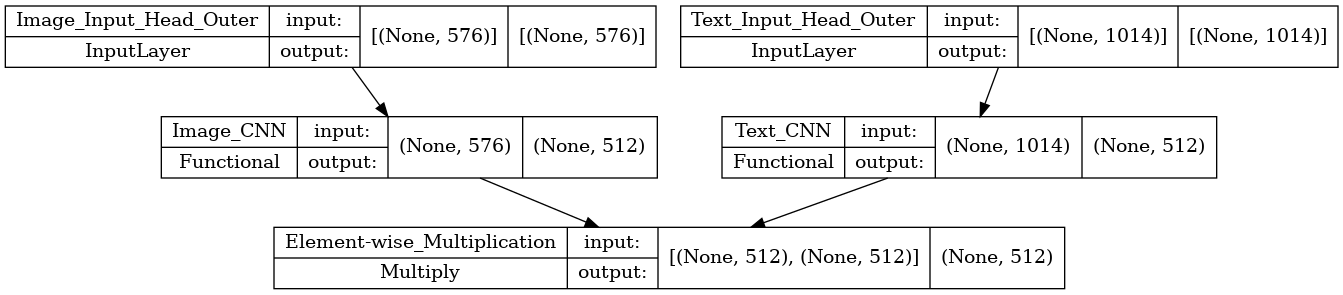

In [31]:
# "Head"

tf.keras.utils.plot_model(mnn_em.model.layers[2],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

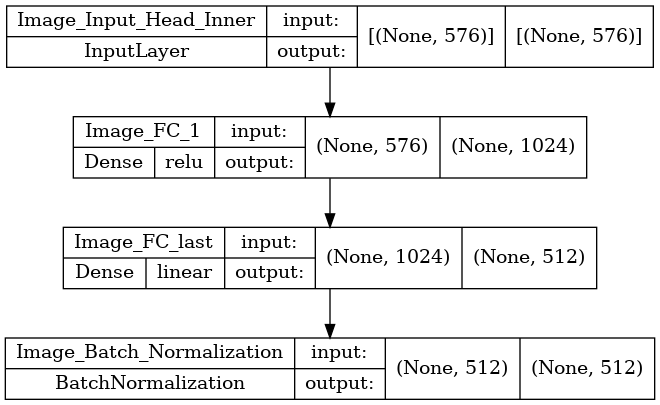

In [32]:
# Image CNN

tf.keras.utils.plot_model(mnn_em.model.layers[2].layers[2],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

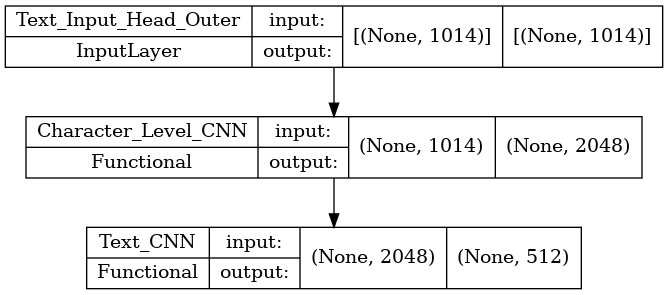

In [33]:
# Text CNN (outer)

tf.keras.utils.plot_model(mnn_em.model.layers[2].layers[3],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

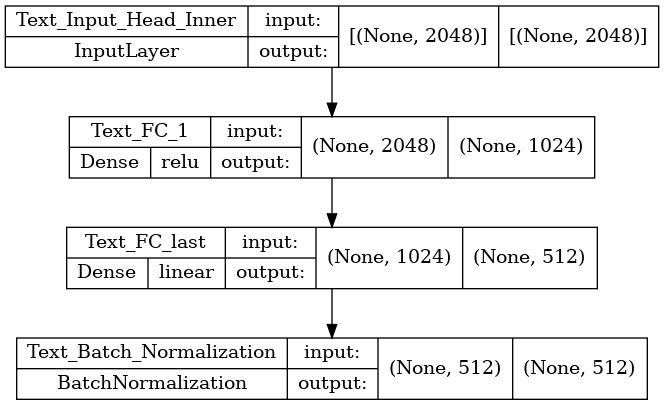

In [34]:
# Text CNN (inner)

tf.keras.utils.plot_model(mnn_em.model.layers[2].layers[3].layers[-1],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

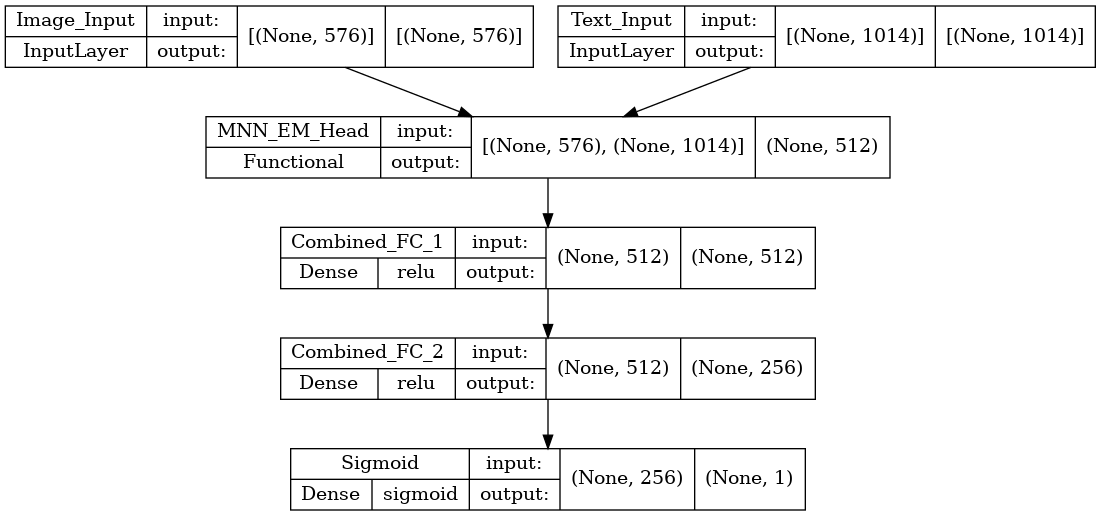

In [35]:
# Full model

tf.keras.utils.plot_model(mnn_em.model,
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

# Callbacks

In [36]:
from utils.metrics import create_callbacks

In [37]:
log_dir = config["model"]["training"]["log_dir"]
model_name = config["model"]["name"]
optimizer_name = config["model"]["training"]["optimizer"]
learning_rate = config["model"]["training"]["learning_rate"]

In [38]:
callbacks = create_callbacks(
    callbacks_list=config["model"]["training"]["callbacks"],
    log_dir=log_dir,
    model_name=model_name,
    img_model_name=img_model.name,
    optimizer_name=optimizer_name,
    learning_rate=learning_rate,
    cls=config["data"]["cls"])

# Training

In [39]:
history = mnn_em.model.fit(
    x=[img_train, text_train],
    y=labels_train,
    epochs=config["model"]["training"]["epochs"],
    validation_data=([img_val, text_val], labels_val),
    batch_size=config["model"]["training"]["batch_size"],
    callbacks=callbacks)

Epoch 1/10
6471/6471 [==============================] - ETA: 0s - loss: 4.5773 - recall: 0.6936 - precision: 0.6236 - binary_accuracy: 0.6374 - cosine_similarity: 0.5000

2023-06-10 08:00:28.457170: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_MSCOCO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_MSCOCO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


6471/6471 [==============================] - 288s 44ms/step - loss: 4.5773 - recall: 0.6936 - precision: 0.6236 - binary_accuracy: 0.6374 - cosine_similarity: 0.5000 - val_loss: 0.9999 - val_recall: 0.7736 - val_precision: 0.6985 - val_binary_accuracy: 0.7198 - val_cosine_similarity: 0.5000
Epoch 2/10
6471/6471 [==============================] - ETA: 0s - loss: 0.6831 - recall: 0.8513 - precision: 0.7526 - binary_accuracy: 0.7858 - cosine_similarity: 0.5000

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_MSCOCO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_MSCOCO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


6471/6471 [==============================] - 278s 43ms/step - loss: 0.6831 - recall: 0.8513 - precision: 0.7526 - binary_accuracy: 0.7858 - cosine_similarity: 0.5000 - val_loss: 0.5869 - val_recall: 0.8110 - val_precision: 0.7754 - val_binary_accuracy: 0.7880 - val_cosine_similarity: 0.5000
Epoch 3/10
6470/6471 [============================>.] - ETA: 0s - loss: 0.4720 - recall: 0.8926 - precision: 0.8020 - binary_accuracy: 0.8361 - cosine_similarity: 0.5000

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_MSCOCO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_MSCOCO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


6471/6471 [==============================] - 281s 43ms/step - loss: 0.4720 - recall: 0.8926 - precision: 0.8020 - binary_accuracy: 0.8361 - cosine_similarity: 0.5000 - val_loss: 0.4489 - val_recall: 0.8906 - val_precision: 0.8033 - val_binary_accuracy: 0.8363 - val_cosine_similarity: 0.5000
Epoch 4/10
6470/6471 [============================>.] - ETA: 0s - loss: 0.3930 - recall: 0.9118 - precision: 0.8255 - binary_accuracy: 0.8596 - cosine_similarity: 0.5000

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_MSCOCO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_MSCOCO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


6471/6471 [==============================] - 284s 44ms/step - loss: 0.3930 - recall: 0.9118 - precision: 0.8255 - binary_accuracy: 0.8596 - cosine_similarity: 0.5000 - val_loss: 0.4294 - val_recall: 0.8640 - val_precision: 0.8178 - val_binary_accuracy: 0.8358 - val_cosine_similarity: 0.5000
Epoch 5/10
6471/6471 [==============================] - 276s 43ms/step - loss: 0.3461 - recall: 0.9230 - precision: 0.8429 - binary_accuracy: 0.8755 - cosine_similarity: 0.5000 - val_loss: 0.4407 - val_recall: 0.8336 - val_precision: 0.8310 - val_binary_accuracy: 0.8320 - val_cosine_similarity: 0.5000
Epoch 6/10
6471/6471 [==============================] - ETA: 0s - loss: 0.3118 - recall: 0.9312 - precision: 0.8575 - binary_accuracy: 0.8882 - cosine_similarity: 0.5000

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_MSCOCO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_MSCOCO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


6471/6471 [==============================] - 281s 43ms/step - loss: 0.3118 - recall: 0.9312 - precision: 0.8575 - binary_accuracy: 0.8882 - cosine_similarity: 0.5000 - val_loss: 0.3750 - val_recall: 0.8884 - val_precision: 0.8407 - val_binary_accuracy: 0.8600 - val_cosine_similarity: 0.5000
Epoch 7/10
6471/6471 [==============================] - 273s 42ms/step - loss: 0.2848 - recall: 0.9377 - precision: 0.8701 - binary_accuracy: 0.8988 - cosine_similarity: 0.5000 - val_loss: 0.3911 - val_recall: 0.8651 - val_precision: 0.8444 - val_binary_accuracy: 0.8528 - val_cosine_similarity: 0.5000
Epoch 8/10
6471/6471 [==============================] - ETA: 0s - loss: 0.2615 - recall: 0.9435 - precision: 0.8817 - binary_accuracy: 0.9085 - cosine_similarity: 0.5000

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_MSCOCO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_MSCOCO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


6471/6471 [==============================] - 281s 43ms/step - loss: 0.2615 - recall: 0.9435 - precision: 0.8817 - binary_accuracy: 0.9085 - cosine_similarity: 0.5000 - val_loss: 0.3633 - val_recall: 0.8720 - val_precision: 0.8613 - val_binary_accuracy: 0.8658 - val_cosine_similarity: 0.5000
Epoch 9/10
6471/6471 [==============================] - 271s 42ms/step - loss: 0.2414 - recall: 0.9490 - precision: 0.8919 - binary_accuracy: 0.9170 - cosine_similarity: 0.5000 - val_loss: 0.3653 - val_recall: 0.8735 - val_precision: 0.8628 - val_binary_accuracy: 0.8673 - val_cosine_similarity: 0.5000
Epoch 10/10
6471/6471 [==============================] - 271s 42ms/step - loss: 0.2236 - recall: 0.9529 - precision: 0.9013 - binary_accuracy: 0.9243 - cosine_similarity: 0.5000 - val_loss: 0.3902 - val_recall: 0.8525 - val_precision: 0.8682 - val_binary_accuracy: 0.8615 - val_cosine_similarity: 0.4999


# Evaluation

## Plot loss and metrics

In [40]:
from utils.metrics import plot_metrics

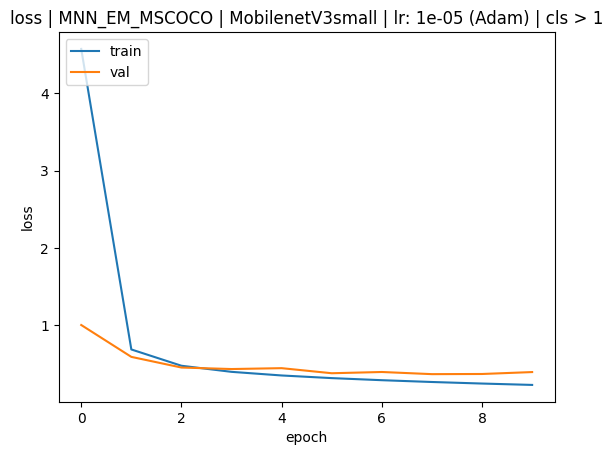

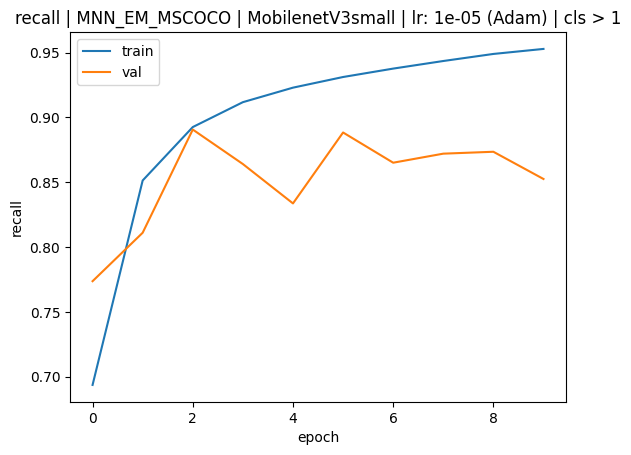

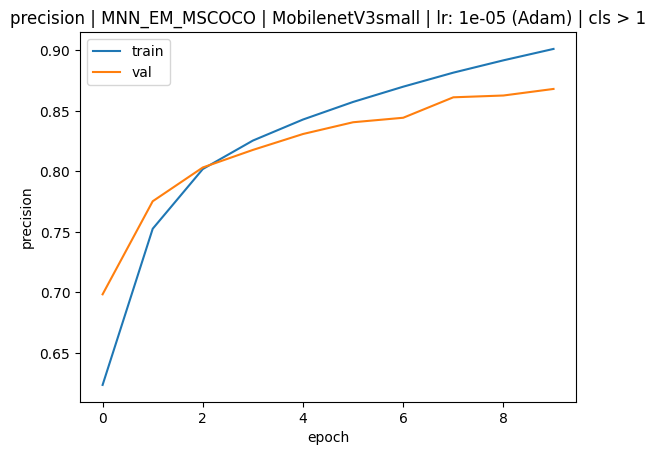

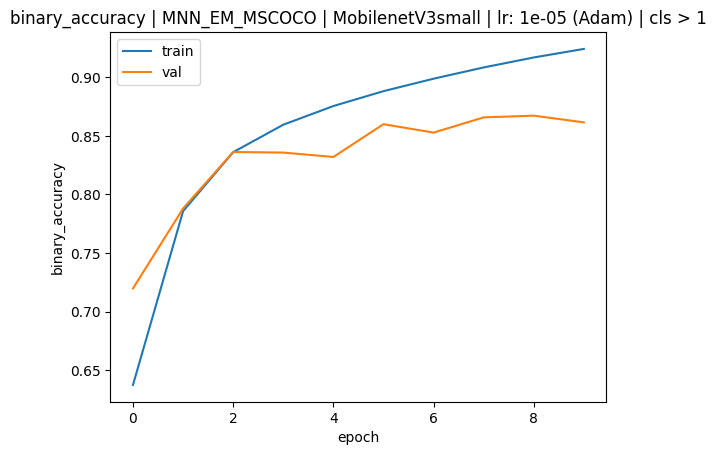

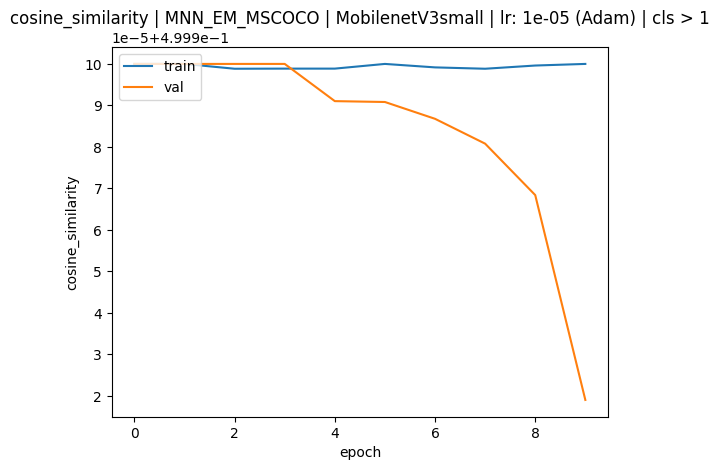

In [41]:
plot_metrics(history.history, config["model"]["training"]["metrics"],
             model_name, img_model.name, optimizer_name, learning_rate,
             config["data"]["cls"])

## Evaluate model and save metrics

In [42]:
from utils.metrics import evaluate

In [43]:
evaluate(mnn_em.model, [img_val, text_val], labels_val,
         log_dir, model_name, img_model.name, optimizer_name, learning_rate,
         config["data"]["cls"])

405308/405308 [==============================] - 1836s 5ms/step - loss: 0.3905 - recall: 0.8525 - precision: 0.8682 - binary_accuracy: 0.8615 - cosine_similarity: 0.4999
